# Variational Autoencoders

Variational Autoencoders (VAEs) are a type of generative model and an extension of traditional autoencoders. They are particularly well-suited for tasks such as generative modeling, anomaly detection, and data compression. VAEs are unique in their ability to generate new data samples similar to the input data by learning the underlying probability distribution.

VAEs consist of two main components &mdash; an encoder network and a decoder network:

* **The Encoder Network**: The encoder network of a VAE typically consists of fully connected layers that map an input to a probability distribution, thus capturing the underlying distribution of the data. This is usually accomplished by outputting the parameters of the distribution. For instance, the encoder network could compress the input data into two separate vectors representing the mean and standard deviation of a multidimensional Gaussian distribution in the latent space.

* **The Decoder Network**: The decoder network reconstructs the original input data from samples drawn from the distribution defined by the encoder, often employing fully connected layers to expand latent variables back into the original data space. Once training is complete, new data points can be generated by sampling from the latent space and passing the sampled variables through the decoder.

The training of a VAE involves optimizing two main components:

* **Reconstruction Loss**: Similar to traditional autoencoders, VAEs aim to minimize the difference between the input data and the reconstructed data. This ensures that the decoder network can accurately reconstruct the original input from the latent space representation.

* **KL Divergence Loss**: [Kullback–Leibler (KL) divergence
](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is a statistical distance measure that determines how one probability distribution is different from a reference probability distribution. In VAEs, KL divergence loss is used to measures the difference between the learned latent space distribution and a prior distribution (e.g., the standard normal distribution). By minimizing this loss, the encoder learns a smooth and continuous latent space, ensuring that samples drawn from this space are meaningful and diverse.

## Example — The MNIST Dataset

To illustrate the use of a VAE, consider the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains images of handwritten digits. A VAE trained on this dataset can learn to map each $28\times28$ pixel image onto a probability distribution. By sampling from these distributions, the VAE can generate new images that resemble the handwritten digits in the dataset, demonstrating its generative capabilities.

# Imports

In [1]:
import gzip
import inspect
import logging
import os
import struct
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.metrics
import sklearn.model_selection

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output, display

# Data Loading

The following variables specify the location and filenames required to read the MNIST dataset.

In [2]:
root = "../datasets"
dirname = "../datasets/MNIST/raw/"
train_x_basename = "train-images-idx3-ubyte.gz"
train_y_basename = "train-labels-idx1-ubyte.gz"
test_x_basename = "t10k-images-idx3-ubyte.gz"
test_y_basename = "t10k-labels-idx1-ubyte.gz"

## Data Loading Helper Functions

### `read_labels`

The `read_labels` function is used to read the target labels of the MNIST dataset from the file specified by `filename`.

In [3]:
def read_labels(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size = struct.unpack(">II", fp.read(8))
        if magic != 2049:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).astype(int)

### `read_images`

The `read_labels` function is used to read the images of the MNIST dataset from the file specified by `filename`.

In [4]:
def read_images(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size, rows, cols = struct.unpack(">IIII", fp.read(16))
        if magic != 2051:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).reshape((-1,28,28)).astype(float)

## Reading the Data

After loading the data, we can see that dataset contains 60,000 training examples and 10,000 validation examples. The labels are stored as integers, while the images are stored as doubles.

In [5]:
## Uncomment the following lines to download the MNIST dataset
# import torchvision.datasets
# torchvision.datasets.MNIST(root=root, download=True, transform=None)

training_images = read_images( os.path.join(dirname, train_x_basename) )
training_labels = read_labels( os.path.join(dirname, train_y_basename) )
validation_images = read_images( os.path.join(dirname, test_x_basename) )
validation_labels = read_labels( os.path.join(dirname, test_y_basename) )

print(f"training_images:   {str(training_images.dtype) : >8} {training_images.shape}")
print(f"training_labels:   {str(training_labels.dtype) : >8} {training_labels.shape}")
print(f"validation_images: {str(validation_images.dtype) : >8} {validation_images.shape}")
print(f"validation_labels: {str(validation_labels.dtype) : >8} {validation_labels.shape}")

training_images:    float64 (60000, 28, 28)
training_labels:      int64 (60000,)
validation_images:  float64 (10000, 28, 28)
validation_labels:    int64 (10000,)


# Data Preprocessing

To effectively train an autoencoder, it essential to first preprocess the data. In this example, we'll rescale the pixel values in the images from the original range of $[0, 255]$ to a normalized range of $[0, 1]$. This normalization process to stabilize the training process and ensure consistent convergence.

In [6]:
training_images = training_images / 255.
validation_images = validation_images / 255.

## Data Visualization

Display a few example images to gain insight into their appearances.

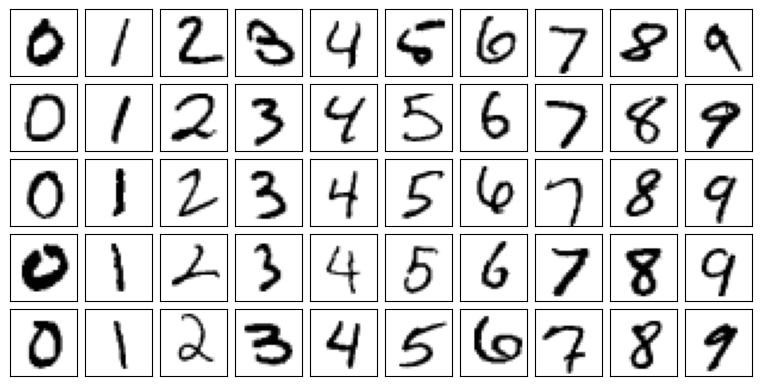

In [7]:
n_rows = 5
n_cols = 10

fig = plt.figure(constrained_layout=True, figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
for col in range(10):
    samples = validation_images[validation_labels == col]
    for row in range(n_rows):
        ax = fig.add_subplot(gs[row,col])
        ax.imshow(samples[row], cmap="binary", vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Digit Distribution

Generate histograms to visualize the distribution of the digits in the dataset. After analyzing these plots, it's clear that there is no data imbalance in the distribution of the target labels (digits).

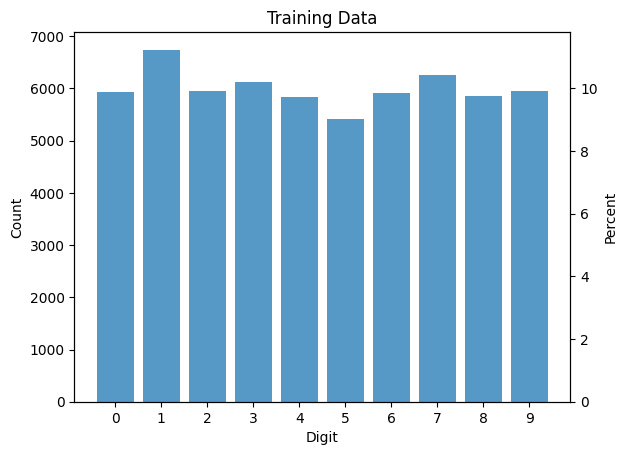

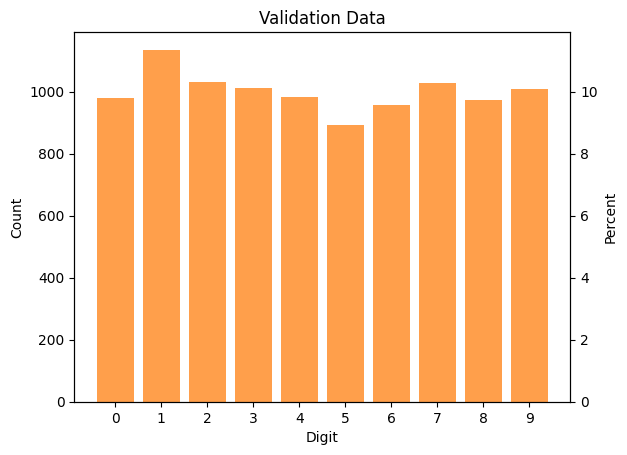

In [8]:
training_digits, training_counts = np.unique(training_labels, return_counts=True)
validation_digits, validation_counts = np.unique(validation_labels, return_counts=True)

colors =  plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig,ax = plt.subplots()
ax.bar(training_digits, training_counts, color=colors[0], alpha=0.75)
ax.xaxis.set_ticks(training_digits)
ax.set_title("Training Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(training_digits, training_counts/training_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

fig,ax = plt.subplots()
ax.bar(validation_digits, validation_counts, color=colors[1], alpha=0.75)
ax.xaxis.set_ticks(validation_digits)
ax.set_title("Validation Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(validation_digits, validation_counts/validation_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

# The Model (VAE)

Our variational autoencoder consists of a fairly simple encoder and decoder:

* **Encoder**: To ensure compatibility of the input images with the fully connected layers in the network, the encoder begins with a layer to flatten the original $28\times 28$ images into 1D vectors using [torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html). This is followed by three fully connected layers with leaky ReLU activation functions following the first two ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html), respectively). These layers progressively reduce the dimensionality of the input data until it reaches a latent space with 10 dimensions. The final layer employs a softmax activation function ([torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)) to produce a probability distribution over the 10 dimensions.

* **Decoder**: The decoder uses three fully connected layers to progressively expand the 10-dimensional latent space back to the original $28\times 28$ pixel space of the original images. The first two layers use leaky ReLU activations while the final layer employs a sigmoid activation function ([torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)). The final step in the decoder is to reshape the 1D vectors back into the original $28\times 28$ image size.

In [9]:
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 10
        self.encoder_ = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(in_features=28*28, out_features=128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=128, out_features=64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=64, out_features=2*self.latent_dim),
        )
        self.decoder_ = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.latent_dim, out_features=64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=64, out_features=128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=128, out_features=28*28),
            torch.nn.Sigmoid(),
            torch.nn.Unflatten(dim=1, unflattened_size=(28,28))
        )

    def encode(self, X):
        return torch.chunk(
            input=self.encoder_(X),
            chunks=2,
            dim=1
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std, device=std.device)
        return mu + eps * std

    def decode(self, X):
        return self.decoder_(X)

    def forward(self, X):
        mu, logvar = self.encode(X)
        return mu, logvar, self.decode( self.reparameterize(mu,logvar) )
        if self.training:
            return mu, logvar, self.decode( self.reparameterize(mu,logvar) )
        else:
            return mu, logvar, self.decode(mu)

    def sample(self, n_samples):
        noise = torch.randn(n_samples, self.latent_dim, device=next(vae.parameters()).device)
        return self.decode(noise)

# Callback Handlers

The following sections define callback handlers to monitor the training progress of the neural network. While the details of these handlers are not particularly important, they play a crucial role in tracking and plotting various aspects of the training process.

## CalculatePerformance

The `CalculatePerformance` callback handler is used to compute and log the network's performance between epochs and mini-batches.

In [10]:
class CalculatePerformance():
    def __init__(
        self,
        criterion,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.training_loss = list()
        self.validation_loss = list()
        self.mini_batch_loss = list()

    @torch.no_grad()
    def _get_performance(self, model, dataloader):
        n_samples = 0
        overall_loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        kld_loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        reconstruction_loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            overall_loss += self.criterion(y_pred, y_train)
            kld_loss += self.criterion.KLD_loss(y_pred, y_train)
            reconstruction_loss += self.criterion.reconstruction_loss(y_pred, y_train)
            if self.criterion.reduction == "mean":
                overall_loss *= len(x_train)
                kld_loss *= len(x_train)
                reconstruction_loss *= len(x_train)
        if self.criterion.reduction == "mean":
            overall_loss /= n_samples
            kld_loss /= n_samples
            reconstruction_loss /= n_samples
        return overall_loss.item(), kld_loss.item(), reconstruction_loss.item()

    def _calculate_training_performance(self, model):
        loss = self._get_performance(model,self.training_dataloader)
        self.training_loss.append(loss)

    def _calculate_validation_performance(self, model):
        loss = self._get_performance(model,self.validation_dataloader)
        self.validation_loss.append(loss)

    def _calculate_performance(self, model, logs):
        if self.training_dataloader is not None:
            self._calculate_training_performance(model)
            logs["training_loss"] = np.asarray(self.training_loss)
        if self.validation_dataloader is not None:
            self._calculate_validation_performance(model)
            logs["validation_loss"] = np.asarray(self.validation_loss)

    def on_training_start(self, n_epochs, model, logs):
        if not self.warm_start:
            self.training_loss = list()
            self.validation_loss = list()
            self.mini_batch_loss = list()
        self._calculate_performance(model, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        while len(self.mini_batch_loss) < epoch:
            self.mini_batch_loss.append(list())
        self.mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(self.mini_batch_loss[-1])

    def on_epoch_end(self, epoch, model, logs):
        self._calculate_performance(model, logs)

## PrintProgress

The `PrintProgress` callback handler prints the performance of the network between epochs and mini-batches. The level of detail is controlled using the `verbose` parameter. It's important to note that the `CalculatePerformance` handler needs to have been invoked prior to invoking this handler.

In [11]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress():
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss[0]:.6f}   Validation Loss: {validation_loss[0]:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            message_level += 4 if self.verbose >= 6 else 0
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
                message_level += 4 if self.verbose >= 6 else 0
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_training_start(self, n_epochs, model, logs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

    def on_epoch_end(self, epoch, model, logs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

## PlotProgress

The `PlotProgress` callback handler serves to visualize the loss and accuracy of the network across epochs and mini-batches. Additionally, it generates plots displaying sample digits and their predictions. Note that this handler requires the invocation of the `CalculateLoss` handler to ensure accurate data for plotting.

In [12]:
class PlotProgress():
    def __init__(self, plotting_samples, limit_loss, device):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_loss[-limit:][:,0], marker=marker, label="Overall Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_loss[-limit:][:,0], marker=marker, label="Overall Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("MSE Loss")
            ax.legend()

    def _plot_loss_components(self, ax, training_loss, validation_loss, limit):
        epochs = None
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_loss[-limit:][:,1], color=colors[0], linestyle="dashed", label="KDL Traning Loss")
            ax.plot(epochs[-limit:], training_loss[-limit:][:,2], color=colors[0], linestyle="dotted", label="MSE Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_loss[-limit:][:,1], color=colors[1], linestyle="dashed", label="KDL Validation Loss")
            ax.plot(epochs[-limit:], validation_loss[-limit:][:,2], color=colors[1], linestyle="dotted", label="MSE Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("MSE Loss")
            ax.legend()

    def _plot_accuracy(self, ax, training_accuracy, validation_accuracy, limit):
        epochs = None
        if training_accuracy is not None:
            epochs = np.arange(len(training_accuracy))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_accuracy[-limit:], marker=marker, label="Traning Accuracy")
        if validation_accuracy is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_accuracy))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_accuracy[-limit:], marker=marker, label="Validation Accuracy")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Accuracy")
            ax.legend()
    
    def _plot_samples(self, fig, gs, samples):
        for ii,sample in enumerate(samples):
            ax = fig.add_subplot(gs[ii])
            ax.imshow(sample, cmap="binary", vmin=0., vmax=1.)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    def _get_grid_size(self, count):
        n_cols = 5
        n_rows = int(np.ceil(count/n_cols))
        return n_rows, n_cols

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, training_accuracy, validation_accuracy, model):
        if epoch % 10 == 0:
            model.to(self.device).eval()
            mu, logvar, outputs = model(
                torch.from_numpy(self.plotting_samples.astype(np.float32)).to(self.device)
            )
            outputs = outputs.to("cpu").numpy()

            clear_output(wait=True)
            n_rows, n_cols = 4, 2
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            self._plot_loss_components(fig.add_subplot(gs[1,0]), training_loss, validation_loss, -1)
            self._plot_loss_components(fig.add_subplot(gs[1,1]), training_loss, validation_loss, self.limit_loss)
            self._plot_samples(fig, gs[2:,0].subgridspec(*self._get_grid_size(len(self.plotting_samples))), self.plotting_samples)
            self._plot_samples(fig, gs[2:,1].subgridspec(*self._get_grid_size(len(self.plotting_samples))), outputs)
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_training_start(self, n_epochs, model, logs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        return

    def on_epoch_end(self, epoch, model, logs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

# Traning

## Training Loop

The `train_model` function implements a standard training loop for a neural network with callbacks. The training loop allows for the integration of various callback handlers while training the neural network model and facilitates monitoring and logging of training progress.

More specifically, a dictionary, `logs`, is used to store training logs generated by callback handlers, and the `on_training_start` method is invoked on each handler. Then, the code performs `n_epochs` iterations of the following:
  - On each epoch, the training data is split into mini-batches using `dataloader`.
  - For each mini-batch, the loop performs forward and backward passes through `model`, using `criterion` to compute the loss, and `optimizer` to update the model parameters.
  - After each mini-batch, registered callbacks are notified by calling `on_mini_batch_end` on each callback handler.
  - At the end of each epoch, the registered callback handlers are notified using the `on_epoch_end` callback method.

In [13]:
def time_function(msg="Elapsed Time:"):
    import time
    from datetime import timedelta
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

@time_function("Training Time:")
def train_model(
    model,
    device,
    dataloader,
    criterion,
    optimizer,
    n_epochs,
    callbacks=None,
    logs=None
):
    if callbacks is None:
        callbacks = list()
    if logs is None:
        logs = dict()
    
    # notify each callback of the beginning of training
    for callback in callbacks:
        model.to(device).eval()
        callback.on_training_start(n_epochs, model, logs)
    
    for epoch in range(1,n_epochs+1):
        for mini_batch,(x_train,y_train) in enumerate(dataloader, 1):
            # zero out the generator gradients
            optimizer.zero_grad()
            model.to(device).train()

            # pass the data through the model and compute the loss
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            # compute the gradients and update the model's weights
            loss.backward()
            optimizer.step()
    
            # notify each callback of the mini batch
            for callback in callbacks:
                model.to(device).eval()
                callback.on_mini_batch_end(
                    epoch, mini_batch, len(dataloader), len(x_train), loss.item(), model, logs
                )
        
        # notify each callback of the end of epoch
        for callback in callbacks:
            model.to(device).eval()
            callback.on_epoch_end(epoch, model, logs)

## Parameters

The following variables control the training loop:
- `n_epochs` &mdash; specifies the number of training epochs
- `batch_size` &mdash; determines the number of samples used in each mini-batch
- `shuffle` &mdash; when set to `True`, the data is reshuffled at the beginning of every epoch
- `device` &mdash; specifies whether calculations are performed on the GPU (set to `'cuda'`) or the CPU (set to `'cpu'`)

The model, `vae`, is also initialized here as it is needed later when the optimizer is defined.

In [14]:
n_epochs = 50
batch_size = 256
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE()

print(device)
print(vae)

cpu
VAE(
  (encoder_): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Linear(in_features=64, out_features=20, bias=True)
  )
  (decoder_): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(28, 28))
  )
)


## Loss Function

The loss function for a variational autoencoder is comprised of two components, namely the reconstruction loss and the KL divergence loss.

* **Reconstruction Loss**: The reconstruction loss is used to measure how well the VAE can reconstruct the input data from its latent representation. For datasets like MNIST, mean squared error (MSE) is a well-suited reconstruction loss.

* **Kullback-Leibler (KL) Divergence Loss**: The KL divergence loss measures the distance between the learned latent distribution and a predefined distribution. In this context, we aim for the learned latent distribution to align with a multivariate standard normal distribution, denoted as $\mathcal{N}(\mathbf{0}, \mathbf{I}_{10})$.

The total loss function for a VAE is the sum of the reconstruction loss and the KL divergence loss.

In [15]:
def gaussian_KLD(mu, logvar, reduction="sum"):
    if reduction == "none":
        return 0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    elif reduction == "mean":
        return torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1), dim=0)
    elif reduction == "sum":
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        raise ValueError(f"{self.reduction} is not a valid value for reduction")
    
class VAELoss(torch.nn.Module):
    def __init__(self, reduction="sum"):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def KLD_loss(self, output, target):
        mu, logvar, output = output
        return gaussian_KLD(mu, logvar, reduction=self.reduction)

    def reconstruction_loss(self, output, target):
        mu, logvar, output = output
        return torch.nn.functional.mse_loss(output, target, reduction=self.reduction)
        # return torch.nn.functional.binary_cross_entropy(output, target, reduction=self.reduction)

    def forward(self, output, target):
        MSE = self.reconstruction_loss(output, target)
        KLD = self.KLD_loss(output, target)
        if self.reduction == "none":
            return MSE, KLD
        elif self.reduction == "mean" or self.reduction == "sum":
            return MSE + KLD
        else:
            raise ValueError(f"{reduction} is not a valid value for reduction")

vae_loss = VAELoss(reduction="sum")

## Optimizer

Here, we define our optimizer, a modified version of gradient descent called Adam ([torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)).

In [16]:
adam_optimizer = torch.optim.Adam(vae.parameters())

## Data Loaders

For ease of training, our dataset will be loaded into a [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and accessed using a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

### Training DataLoader

In [17]:
training_tensor = torch.from_numpy(training_images.astype(np.float32))
training_dataset = torch.utils.data.TensorDataset(training_tensor, training_tensor)
training_dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
)

### Validation DataLoader

In [18]:
validation_tensor = torch.from_numpy(validation_images.astype(np.float32))
validation_dataset = torch.utils.data.TensorDataset(validation_tensor, validation_tensor)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Initialize Callbacks

Here we initialize the callback objects and add them to the `callbacks` list. To reduce the computation required to log the training and validation loss between each epoch, a subset of size $500=50\cdot10$ from their respective datasets is utilize.

In [19]:
n_samples = 50
training_idx = np.concatenate([
    np.where(training_labels == ii)[0][:n_samples]
    for ii in range(10)
])
validation_idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
training_tensor = torch.from_numpy(training_images[training_idx].astype(np.float32))
validation_tensor = torch.from_numpy(validation_images[validation_idx].astype(np.float32))
calculate_performance = CalculatePerformance(
    criterion=vae_loss,
    training_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(training_tensor, training_tensor),
        batch_size=len(training_tensor)
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(validation_tensor, validation_tensor),
        batch_size=len(training_tensor)
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=6
)

n_samples = 5
idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
plotting_samples = validation_images[idx]
plot_progress = PlotProgress(
    plotting_samples=plotting_samples,
    limit_loss=10,
    device=device
)

callbacks = [calculate_performance, print_progress, plot_progress]

## Train the Model

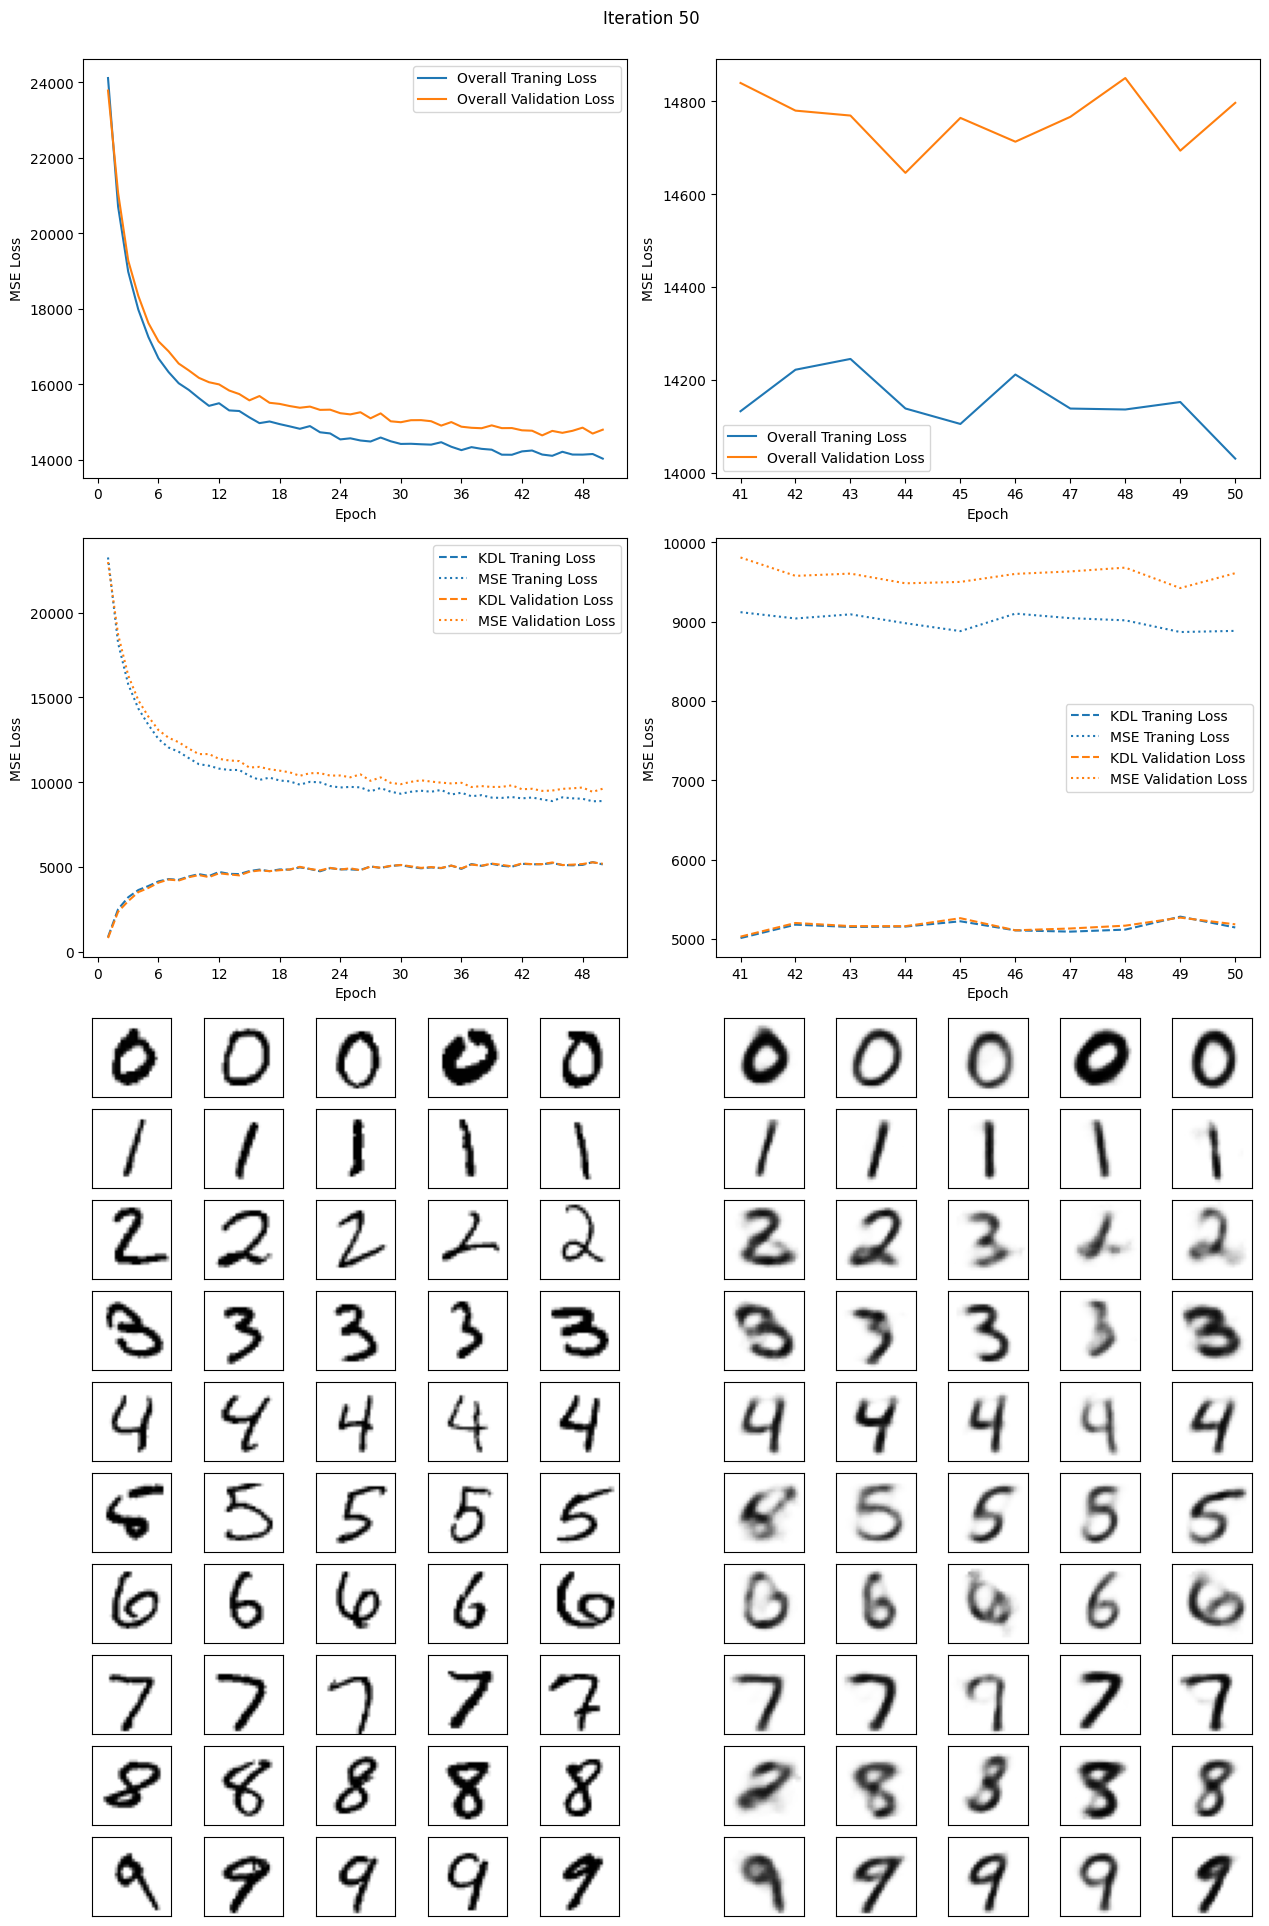

Training Time: 0:02:07.985673


In [20]:
logs = dict()
train_model(
    model=vae,
    device=device,
    dataloader=training_dataloader,
    criterion=vae_loss,
    optimizer=adam_optimizer,
    n_epochs=n_epochs,
    callbacks=callbacks,
    logs=logs
)

# Performance Evaluation

The following section examines the reconstruction error of the trained autoencoder. Although the training and validation loss curves may suggest overfitting, a closer analysis of the reconstruction error suggests otherwise.

## Performance Evaluation Helper Functions

### `calculate_reconstruction_error`

The following function computes the reconstruction error of `model` on `images` under MSE loss.

In [21]:
@torch.no_grad()
def compute_reconstruction_error(images, model, device):
    images = images.astype(np.float32)
    model.to(device).eval()
    mu, logvar, outputs = model( torch.from_numpy(images).to(device) )
    outputs = outputs.cpu().numpy()
    return np.square(outputs - images).reshape(len(images),-1).mean(axis=1)

### `compute_mse_summary_statistics_by_digit`

The following function divides `images` by digit using `labels` and calculates the MSE loss for each sample reconstructed by `model`. It then computes summary statistics of the per digit MSE loss values and it returns these statistics in a Pandas dataframe.

In [22]:
def compute_mse_summary_statistics_by_digit(images, labels, model, device):
    mse = compute_reconstruction_error(images, model, device)
    dfs = [
        pd.DataFrame(mse[labels==ii], columns=[ii]).describe()
        for ii in range(10)
    ] + [pd.DataFrame(mse, columns=["Overall"]).describe()]
    return mse, pd.concat(dfs, axis=1).transpose()

## Reconstruction Error

By examining the per-digit reconstruction error, we can see that our autoencoder has the least difficulty reconstructing 1's, while 2's and 8's present the most challenges.

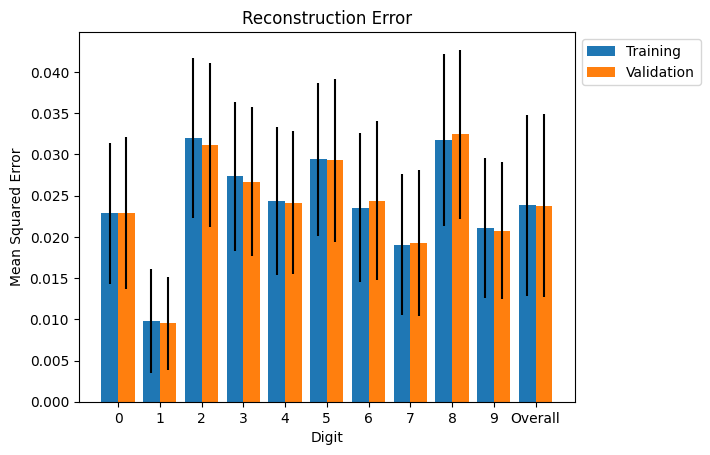

,count,mean,std,min,25%,50%,75%,max
Training,,,,,,,,
0,5923.0,0.022837,0.008591,0.006713,0.016782,0.021327,0.026966,0.084249
1,6742.0,0.009839,0.006298,0.001272,0.006179,0.008391,0.011468,0.092908
2,5958.0,0.031969,0.009727,0.009730,0.024929,0.030539,0.037705,0.085238
3,6131.0,0.027362,0.009015,0.008787,0.020899,0.025967,0.032131,0.081923
4,5842.0,0.024321,0.008979,0.007344,0.018020,0.022563,0.028825,0.087908
5,5421.0,0.029390,0.009272,0.009773,0.022797,0.027759,0.034166,0.091712
6,5918.0,0.023540,0.009033,0.006618,0.017129,0.021714,0.027857,0.088896
7,6265.0,0.019061,0.008527,0.004656,0.013047,0.017084,0.022891,0.065687
8,5851.0,0.031764,0.010404,0.009510,0.024266,0.030259,0.037522,0.093639


,count,mean,std,min,25%,50%,75%,max
Validation,,,,,,,,
0,980.0,0.022923,0.009210,0.007788,0.016201,0.020976,0.027553,0.076713
1,1135.0,0.009532,0.005635,0.002264,0.006106,0.008183,0.011370,0.060417
2,1032.0,0.031180,0.009959,0.010618,0.024339,0.029387,0.036448,0.082495
3,1010.0,0.026712,0.009000,0.009301,0.020473,0.025046,0.030424,0.069886
4,982.0,0.024130,0.008665,0.007253,0.017791,0.022592,0.028981,0.064534
5,892.0,0.029317,0.009887,0.010631,0.022350,0.027945,0.033762,0.095421
6,958.0,0.024407,0.009659,0.007167,0.017520,0.022578,0.029057,0.068095
7,1028.0,0.019255,0.008842,0.005394,0.012846,0.017412,0.023480,0.073864
8,974.0,0.032422,0.010286,0.010223,0.025408,0.030657,0.038367,0.085633


In [23]:
training_mse, training_df = compute_mse_summary_statistics_by_digit(training_images, training_labels, vae, device)
validation_mse, validation_df = compute_mse_summary_statistics_by_digit(validation_images, validation_labels, vae, device)
training_df.index.name = "Training"
validation_df.index.name = "Validation"

width = 0.4
xx = np.arange(len(validation_df.index))
fig,ax = plt.subplots()
ax.bar(xx - width/2, training_df["mean"], width=width, label="Training")
plt.errorbar(xx - width/2, training_df["mean"], training_df["std"], color="black", linestyle="")
ax.bar(xx + width/2, validation_df["mean"], width=width, label="Validation")
plt.errorbar(xx + width/2, validation_df["mean"], validation_df["std"], color="black", linestyle="")
ax.xaxis.set_ticks(xx)
ax.xaxis.set_ticklabels(validation_df.index)
ax.set_xlabel("Digit")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Reconstruction Error")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

display(training_df, validation_df)

# Visual Evaluation

For a visual evaluation of our autoencoder, we can look at digits with the best and worst reconstruction errors.

## Visual Evaluation Helper Functions

### `plot_image`

The following function plots a single image using the specified colormap on the given axis. If `ax` is `None`, a new figure is created and displayed.

In [24]:
def plot_image(image, cmap="binary", ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig,ax = plt.subplots(figsize=(0.75,0.75))
    ax.imshow(image, cmap=cmap, vmin=0., vmax=1.)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if ax_is_none:
        plt.show()

### `plot_images`

The following function plots each image in `images` using the gridspec `gs` on `fig`. It is assumed that the gridspec is large enough to accommodate all the images.

In [25]:
def plot_images(images, fig, gs):
    for ii,image in enumerate(images):
        plot_image(image, ax=fig.add_subplot(gs[ii]))

### `plot_best_reconstructed_images`

The following function identifies the images with the smallest reconstruction error and plots them.
- `images` &mdash; the collection of images
- `labels` &mdash; used to determine the class of each image in `images`
- `mse` &mdash; the mse reconstruction error for the images
- `n_samples` &mdash; the number of samples of each digit to plot
- `model` &mdash; the model used to reconstruct the images
- `device` &mdash; the computing device to run the model on
- `title` &mdash; the title for the plot

In [26]:
@torch.no_grad()
def plot_best_reconstructed_images(images, labels, mse, n_samples, model, device, title):
    images = images.astype(np.float32)
    tmp_idx = np.argsort(mse)
    sample_images = np.concatenate([
        images[tmp_idx][
            np.where(labels[tmp_idx] == ii)[0][:n_samples]
        ]
        for ii in range(10)
    ])

    model.to(device).eval()
    mu, logvar, reconstructed_images = model( torch.from_numpy(sample_images).to(device) )
    reconstructed_images = reconstructed_images.cpu().numpy()
    
    n_rows = 10
    n_cols = n_samples
    fig = plt.figure(figsize=(2*0.75*n_cols,0.75*n_rows))
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, wspace=0.05, figure=fig)
    plot_images(sample_images, fig, gs[0,0].subgridspec(n_rows, n_cols, wspace=0, hspace=0))
    plot_images(reconstructed_images, fig, gs[0,1].subgridspec(n_rows, n_cols, wspace=0, hspace=0))
    fig.suptitle(title, y=0.925)
    plt.show()

## Reconstructed Images

The following plots display some of the best, worst, and average images for each of the 10 digits, based on their reconstruction error. The images in the grid on the left are the original MNIST images, while the images in the grid on the right are the reconstructed versions generated by the autoencoder.

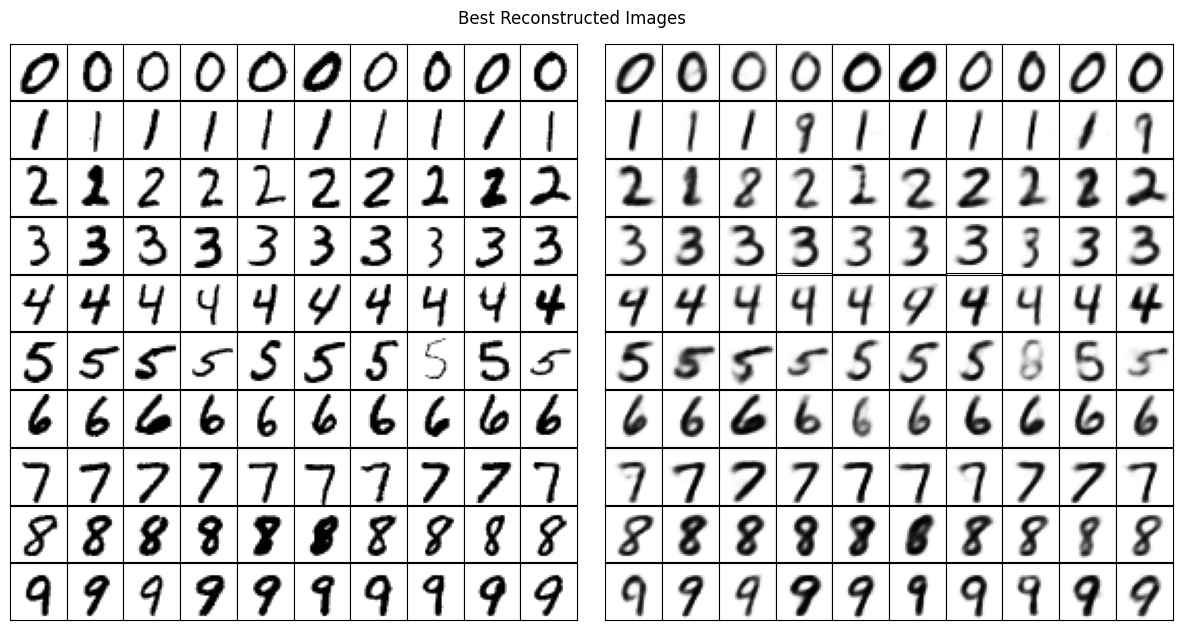

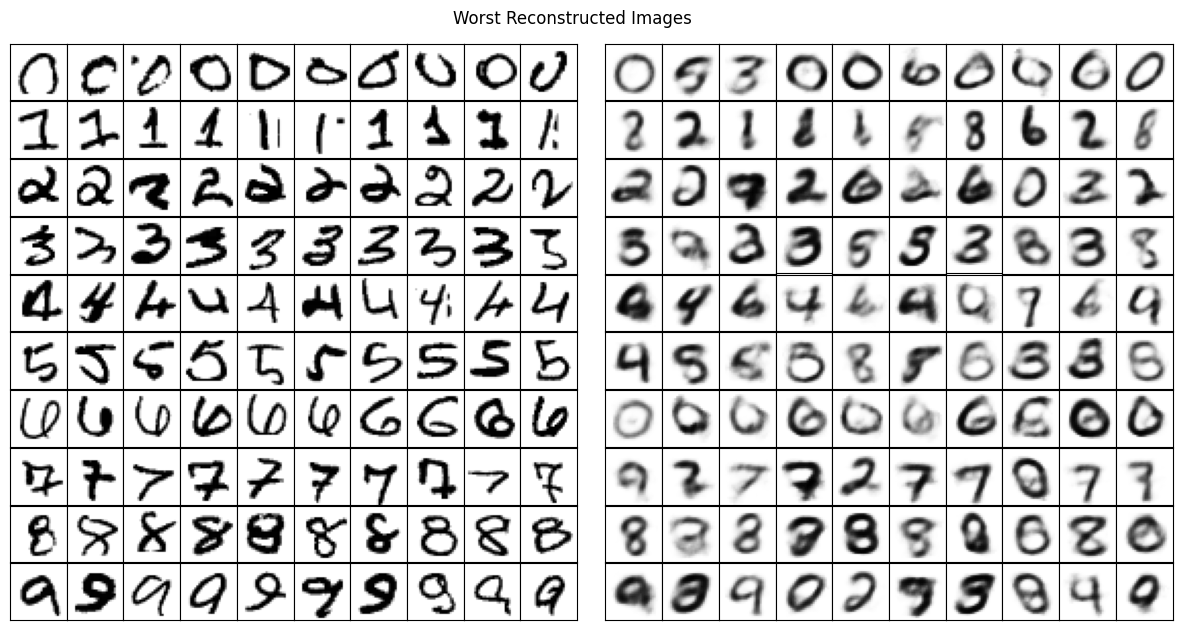

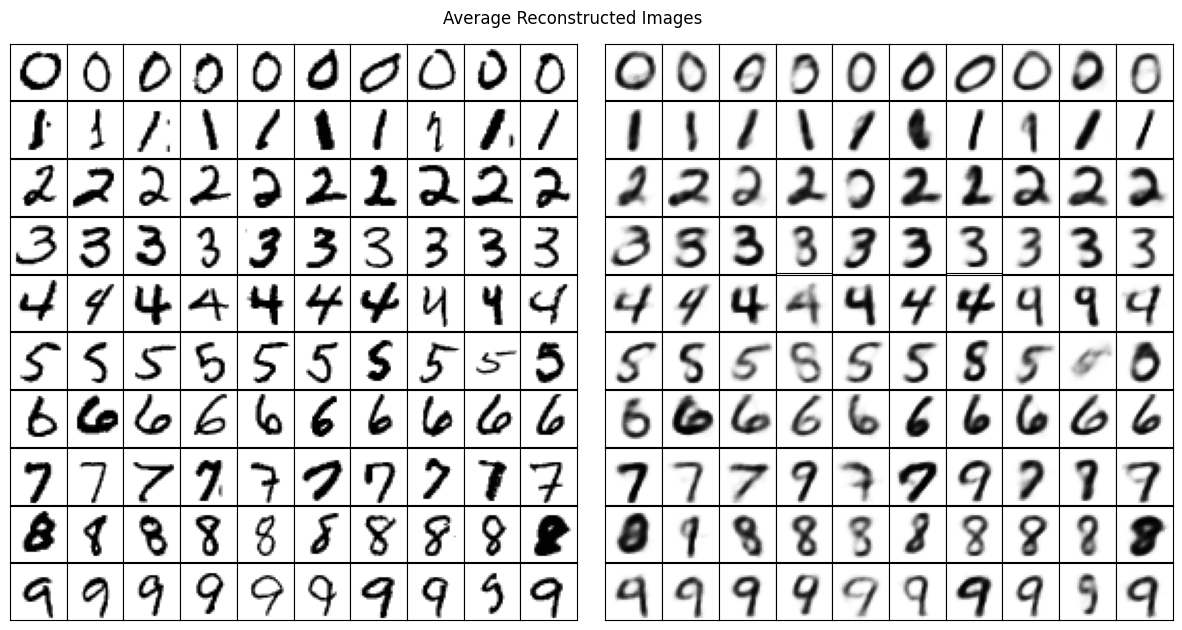

In [27]:
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=validation_mse,
    n_samples=10,
    model=vae,
    device=device,
    title="Best Reconstructed Images"
)

# multiply mse by -1 to plot the worset reconstructed images
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=-1*validation_mse,
    n_samples=10,
    model=vae,
    device=device,
    title="Worst Reconstructed Images"
)

# multiply mse by -1 to plot the worset reconstructed images
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=np.abs(validation_mse - validation_mse.mean()),
    n_samples=10,
    model=vae,
    device=device,
    title="Average Reconstructed Images"
)

# Generative Modeling

Once our VAE has been trained, we can sample from the latent space and decode the latent variables to generate new synthetic data. This section illustrates some of the synthetic digits generated by our VAE.

## Sampling from the Standard Normal

By sampling from the multivariate standard normal $\mathcal{N}(\mathbf{0}, \mathbf{I}_{10})$ and decoding the results, we can obtain synthetic data from our VAE. This can be accomplished using the `sample` method provided by our VAE.

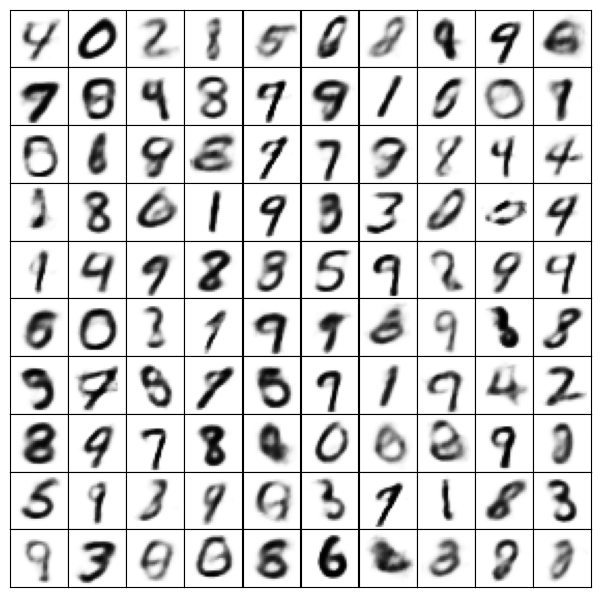

In [28]:
n_rows = 10
n_cols = 10
with torch.no_grad():
    vae.to(device).eval()
    sample_images = vae.sample(n_rows*n_cols).cpu().numpy()
fig = plt.figure(figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, wspace=0, hspace=0, figure=fig)
plot_images(sample_images, fig, gs)
plt.show()

## Sampling Across the Space

By encoding an image of a digit, we can obtain the parameters of the distribution to which it was mapped (i.e., the mean and log-variance). Encoding all the images in the training data, we can gain insight into the range of distributions comprising the latent space. Once we have an understanding of the range of the latent space, we can sample across it and decode the results to obtain synthetic data.

[-3.5207028 -3.541193  -3.2527013 -4.1405764 -1.1076624 -2.763889
 -3.3034663 -3.377689  -1.0805372 -4.0973763]


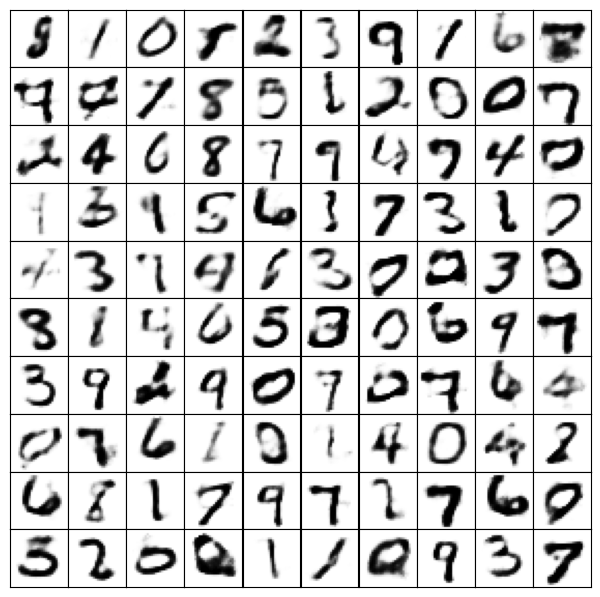

In [29]:
n_rows = 10
n_cols = 10
with torch.no_grad():
    vae.to(device).eval()
    mu, logvar = map(
        lambda x: x.cpu().numpy(),
        vae.encode( torch.from_numpy(validation_images.astype(np.float32)).to(device) )
    )
    std = np.exp(0.5 * logvar)
    vmin = mu.min(axis=0) - std.max(axis=0)
    vmax = mu.max(axis=0) + std.max(axis=0)
    print(vmin)
    sample_codes = np.random.uniform(low=vmin, high=vmax, size=(n_rows*n_cols,len(vmin)))
    sample_images = vae.decode( torch.from_numpy(sample_codes.astype(np.float32)).to(device) ).cpu().numpy()
fig = plt.figure(figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, wspace=0, hspace=0, figure=fig)
plot_images(sample_images, fig, gs)
plt.show()

## Sample from Examples

In the previous two examples, many of the images are recognizable as digits but lack visual quality. Recall that one of the primary reasons for incorporating KL divergence into the loss function is to ensure that the generated samples are both meaningful and diverse. However, in this instance, it did not perform as well as hoped.

Rather than generating images arbitrarily (i.e., by randomly sampling across the latent space), we can leverage the learned distributions from the VAE to create new images. This ensures that the new images retain the characteristics and details of the original image, thus resulting in higher-quality and more realistic output. To accomplish this, we start by encoding an image to acquire the learned probability distribution associated with it from the VAE. Then, we sample from this distribution to generate new images. Unfortunately, these images often bear a strong resemblance to the original image, sometimes appearing visually indistinct.

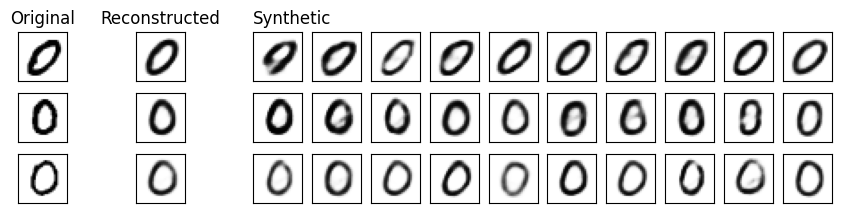

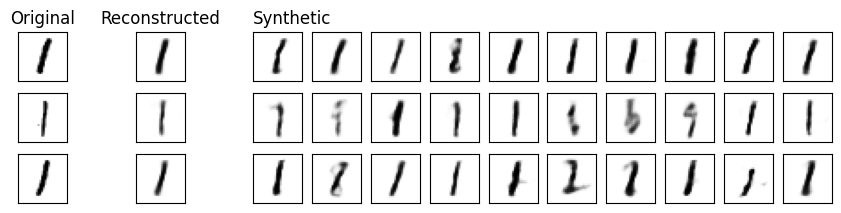

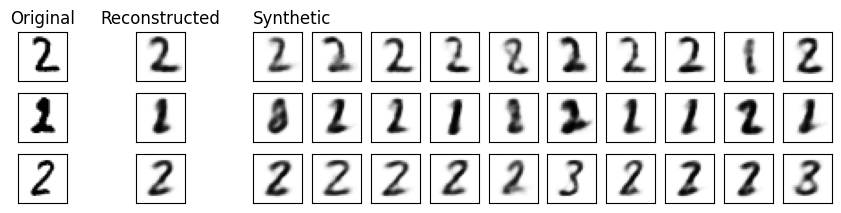

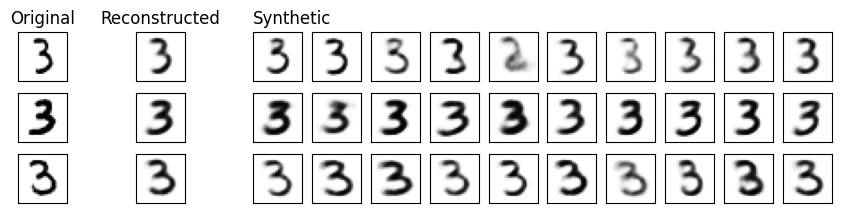

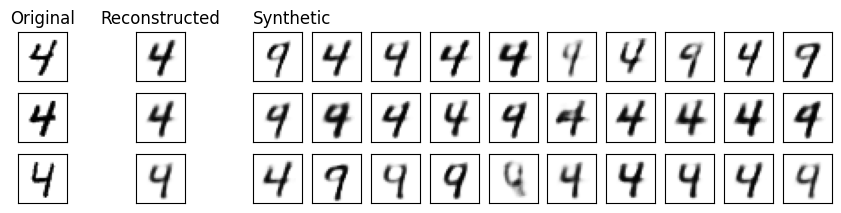

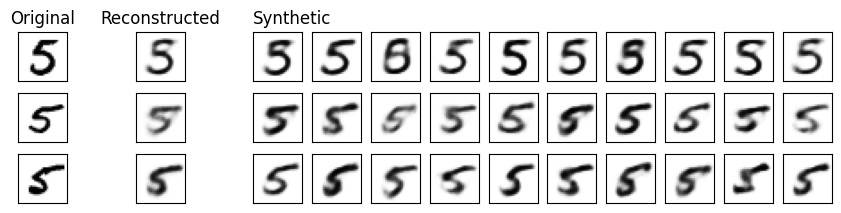

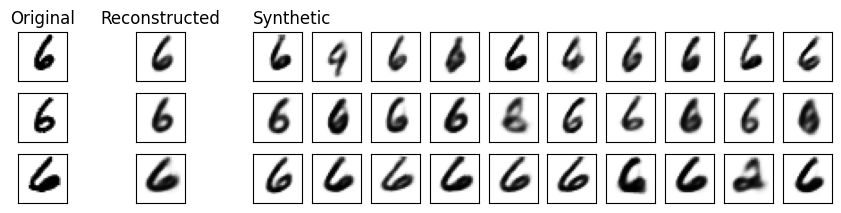

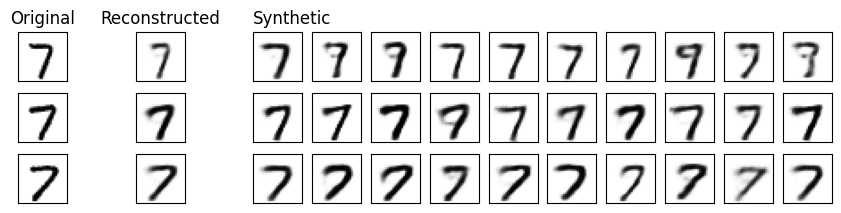

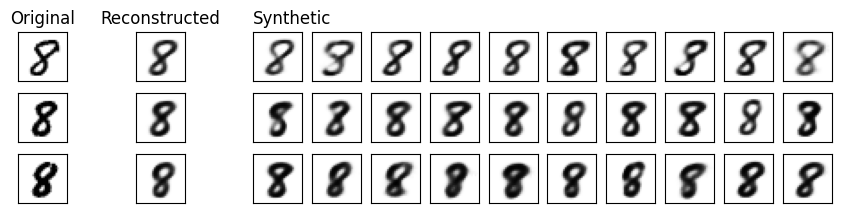

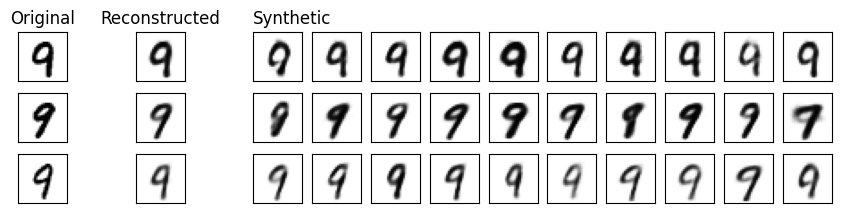

In [30]:
n_samples = 3
n_generated = 10
random = np.random.RandomState(0)
idx = validation_mse.argsort()

for digit in np.unique(validation_labels):
    images = validation_images[idx][validation_labels[idx] == digit][:n_samples]

    with torch.no_grad():
        mus, logvars, reconstructed_images = map(
            lambda x: x.numpy(),
            vae( torch.from_numpy(images.astype(np.float32)).to(device) )
        )
        stds = np.exp(0.5 * logvars)

    n_rows = n_samples
    n_cols = n_generated + 4
    fig = plt.figure(figsize=(n_cols*0.75, n_rows*0.75))
    gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
    for row,(image,reconstructed_image,mu,std) in enumerate(zip(images, reconstructed_images, mus, stds)):
        synthetic_codes = random.normal(loc=mu, scale=2*std, size=(n_generated, len(std)))
        with torch.no_grad():
            synthetic_images = vae.decode( torch.from_numpy(synthetic_codes.astype(np.float32)).to(device) ).cpu().numpy()
        
        ax = fig.add_subplot(gs[row, 0])
        plot_image(image, ax=ax)
        if row == 0:
            ax.set_title("Original")
        ax = fig.add_subplot(gs[row, 2])
        plot_image(reconstructed_image, ax=ax)
        if row == 0:
            ax.set_title("Reconstructed")
        for col in range(len(synthetic_images)):
            ax = fig.add_subplot(gs[row, col+4])
            plot_image(synthetic_images[col], ax=ax)
            if row == 0 and col == 0:
                ax.set_title("Synthetic", loc="left")
    plt.show()